In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, FuncFormatter

In [3]:
df=pd.read_csv('/kaggle/input/dataset/amaretto_dataset_anon.csv.csv')
df.head()

,Transaction ID,Originator,Originator_ID,EntryDate,InputOutput,Market,Product ISIN,Product Type,Product Class,Normalized Amount,Currency,Anomaly
0,I9Q3S5YYLCQX,Client_087,_XID,2019-01-01 17:55:33,Sell,Market2,ISN-X01-LRBXBXN,FutureCommodity,Trade,10317357.93,Currency1,0
1,VFZ6INAXVYJV,Client_019,_XID,2019-01-01 18:52:34,Sell,Market1,ISN-X01-856Z8OC,FX,Trade,31042.04,Currency2,0
2,HXOA8DNPX1OE,Client_385,_XID,2019-01-01 15:21:09,Sell,Market1,ISN-X01-5CW2HUF,SimpleTransfer,Trade,35910.53,Currency1,0
3,O9W5IR932XT1,Client_276,_XID,2019-01-01 20:02:36,Sell,Market1,ISN-X01-AQ848H7,FutureEquity,Trade,79630.92,Currency2,0
4,84KF31TPK1LU,Client_049,_XID,2019-01-01 09:06:58,Buy,Market1,ISN-X01-7JWB2C7,FX,Trade,434370.69,Currency1,0


In [4]:
print('Duplicados dataset original: ', df.duplicated().sum())

Duplicados dataset original:  0


In [5]:
print('Nulos dataset original:', df.isnull().sum())

Nulos dataset original: Transaction ID       0
Originator           0
Originator_ID        0
EntryDate            0
InputOutput          0
Market               0
Product ISIN         0
Product Type         0
Product Class        0
Normalized Amount    0
Currency             0
Anomaly              0
dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


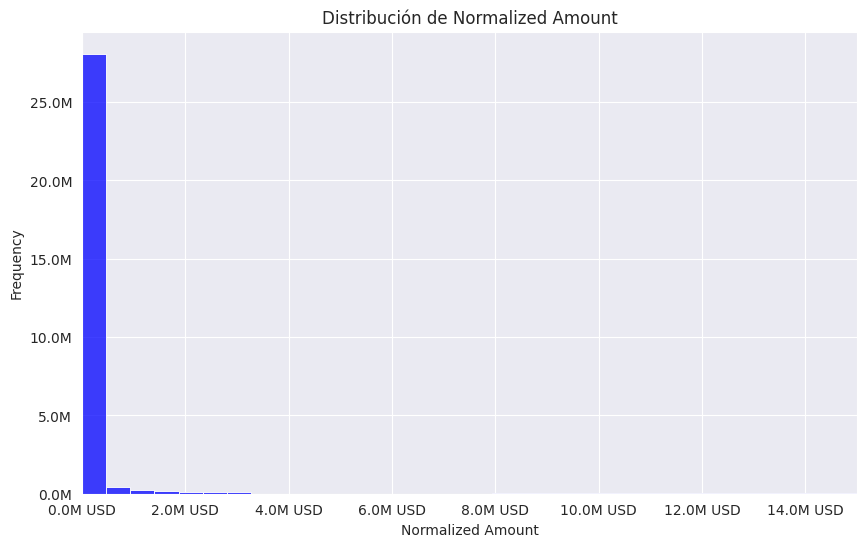

In [25]:
def millones(x, pos):
    return f'{x*1e-6:.1f}M'

def millones2(x, pos):
    return f'{x*1e-6:.1f}M USD'

#sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
sns.histplot(df['Normalized Amount'], bins=80, color='blue')

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(FuncFormatter(millones2)) 
ax.yaxis.set_major_formatter(FuncFormatter(millones))  

plt.xlim(0, 15000000) 

plt.xlabel('Normalized Amount')
plt.ylabel('Frequency')
plt.title('Distribución de Normalized Amount')
plt.show()

In [27]:
percentage_below_1M = (df[df['Normalized Amount'] < 1000000].shape[0] / df.shape[0]) * 100

percentage_below_40K = (df[df['Normalized Amount'] < 40000].shape[0] / df.shape[0]) * 100

print(f"El {percentage_below_1M:.2f}% de las transacciones tienen un monto menor a 1M USD,")
print(f"y el {percentage_below_40K:.2f}% de ellas tienen un monto menor a 40K USD.")

El 96.02% de las transacciones tienen un monto menor a 1M USD,
y el 57.17% de ellas tienen un monto menor a 40K USD.


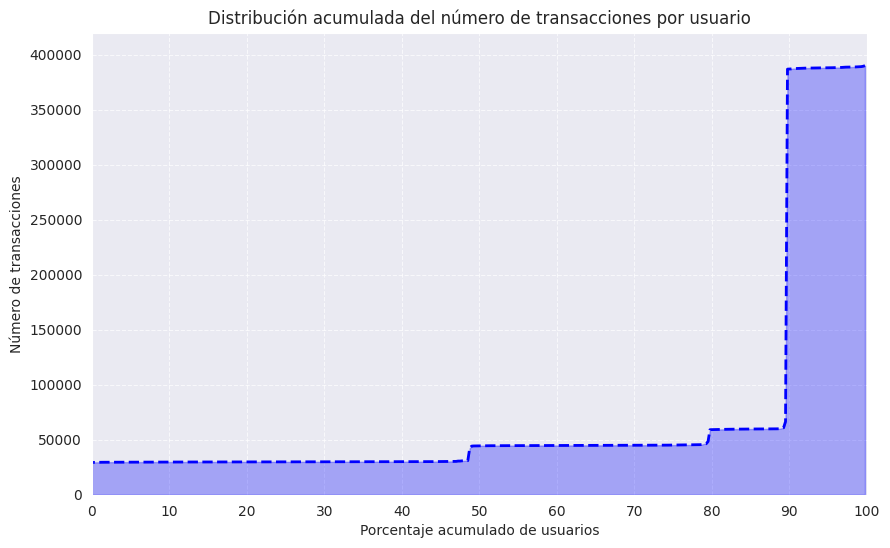

In [59]:
transactions_per_user = df.groupby('Originator')['Normalized Amount'].count()
transactions_per_user_sorted = transactions_per_user.sort_values(ascending=False)
cumulative_percentage = (1 - transactions_per_user_sorted.rank(method='first', ascending=False) / len(transactions_per_user_sorted)) * 100

plt.figure(figsize=(10, 6))
plt.fill_between(cumulative_percentage, transactions_per_user_sorted.values, color='blue', alpha=0.3)
plt.plot(cumulative_percentage, transactions_per_user_sorted.values, color='blue', lw=2, linestyle='--')


plt.title('Distribución acumulada del número de transacciones por usuario')
plt.xlabel('Porcentaje acumulado de usuarios')
plt.ylabel('Número de transacciones')

plt.ticklabel_format(style='plain', axis='y') 
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.xlim(0, 100) 
plt.ylim(0, 420000) 
plt.show()

In [50]:
transactions_per_user_sorted

Originator
Client_039    390050
Client_036    389495
Client_026    389168
Client_024    389043
Client_014    388965
               ...  
Client_198     29447
Client_107     29444
Client_139     29414
Client_093     29407
Client_089     29258
Name: Normalized Amount, Length: 400, dtype: int64

In [31]:
total_transactions_df = df['Transaction ID'].count()
df['num_transactions_proportion'] = 1 / total_transactions_df

df['EntryDate'] = pd.to_datetime(df['EntryDate'])
df['Weekday'] = df['EntryDate'].dt.weekday
df['Hour'] = df['EntryDate'].dt.hour

df['Morning'] = df['Hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)  # Mañana (6:00 - 11:59)
df['Evening'] = df['Hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)  # Tarde (12:00 - 17:59)
df['Night'] = df['Hour'].apply(lambda x: 1 if 18 <= x < 24 or 0 <= x < 6 else 0)  # Noche (18:00 - 23:59), (00:00 - 5:59)

condition_round_amount = ((df['Normalized Amount'].apply(lambda x: str(x).count('000.0')) >= 1) & (df['Normalized Amount'] == df['Normalized Amount'].round()))
df['Round_Amount_Condition'] = condition_round_amount.astype(int)

condition_small_amount = ((df['Normalized Amount'] < 1177.44) & (df['Normalized Amount'] > 420.65) & (df['Product Class'] == 'Cash in / out (withdrawal), Security in / out'))
df['Small_Amount_Condition'] = condition_small_amount

condition_sell = df['InputOutput'] == 'Sell'
df['Sell_Condition'] = condition_sell
condition_buy = df['InputOutput'] == 'Buy'
df['Buy_Condition'] = condition_buy

inoutdelta = (df['InputOutput'] == 'Buy').astype(int) - (df['InputOutput'] == 'Sell').astype(int)
df['InputOutput_Delta'] = inoutdelta

condition_sell_cash = df['Normalized Amount'].where(condition_sell & (df['Product Class'] == 'Cash in / out (withdrawal), Security in / out'), 0)
df['condition_sell_cash'] = condition_sell_cash

condition_sell_cash2 = df['Normalized Amount'].where(condition_sell & (df['Product Type'] == 'SimpleTransfer'), 0)
df['condition_sell_cash2'] = condition_sell_cash2

aggregated_df = df.groupby(['Originator', 'Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Anomaly']).agg(
    num_transactions=('num_transactions_proportion', 'count'),
    total_amount_traded=('Normalized Amount', 'sum'),
    transactions_count_small_amount=('Small_Amount_Condition', 'sum'),
    transactions_count_round_amount=('Round_Amount_Condition', 'sum'),
    transactions_count_amount_sell=('Sell_Condition', 'sum'),
    transactions_count_amount_buy=('Buy_Condition', 'sum'),
    cash_out_withdrawal_security_out=('condition_sell_cash', 'sum'),
    simpletranfer=('condition_sell_cash2', 'sum'),
    inputoutput_delta=('InputOutput_Delta', 'sum')
).reset_index()

df.drop(columns=['Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Round_Amount_Condition', 'Small_Amount_Condition', 'Sell_Condition', 'Buy_Condition', 'InputOutput_Delta', 'condition_sell_cash', 'condition_sell_cash2','num_transactions_proportion'], inplace=True)

In [32]:
aggregated_df.head(10)

,Originator,Weekday,Hour,Morning,Evening,Night,Anomaly,num_transactions,total_amount_traded,transactions_count_small_amount,transactions_count_round_amount,transactions_count_amount_sell,transactions_count_amount_buy,cash_out_withdrawal_security_out,simpletranfer,inputoutput_delta
0,Client_001,0,0,0,0,1,0,7,2.697422e+06,1,0,4,3,50517.36,51875.82,-1
1,Client_001,0,1,0,0,1,0,3,1.436519e+06,0,0,2,1,0.00,0.00,-1
2,Client_001,0,2,0,0,1,0,9,2.780018e+05,0,0,5,4,47436.03,454.04,-1
3,Client_001,0,3,0,0,1,0,11,4.021485e+05,0,0,6,5,34542.54,82329.73,-1
4,Client_001,0,4,0,0,1,0,11,1.504425e+07,1,0,4,7,0.00,0.00,3
5,Client_001,0,5,0,0,1,0,12,2.900135e+06,0,0,7,5,0.00,32782.70,-2
6,Client_001,0,6,1,0,0,0,7,1.719008e+05,1,0,5,2,581.05,656.11,-3
7,Client_001,0,7,1,0,0,0,430,1.121335e+08,14,0,182,248,980452.25,829255.41,66
8,Client_001,0,8,1,0,0,0,458,1.138423e+08,9,0,219,239,20441426.72,29282488.58,20
9,Client_001,0,9,1,0,0,0,457,1.738604e+08,10,0,215,242,20743247.65,1429956.39,27


In [34]:
aggregated_df.num_transactions.sum()

29704090

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


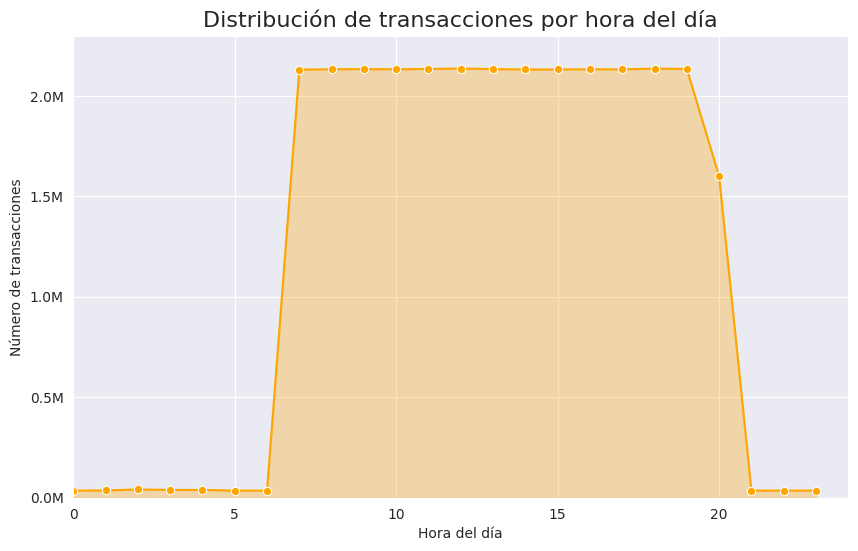

In [49]:
sns.set_style("darkgrid")

transactions_per_hour = aggregated_df.groupby('Hour')['num_transactions'].sum()

def millones(x, pos):
    return f'{x*1e-6:.1f}M'

plt.figure(figsize=(10, 6))
sns.lineplot(x=transactions_per_hour.index, y=transactions_per_hour.values, marker='o', color='orange')
plt.fill_between(transactions_per_hour.index, transactions_per_hour.values, color='orange', alpha=0.3)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.title('Distribución de transacciones por hora del día', fontsize=16)
plt.xlabel('Hora del día')
plt.ylabel('Número de transacciones')

ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(millones))
plt.xlim(0, 24) 
plt.ylim(0, 2300000) 
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


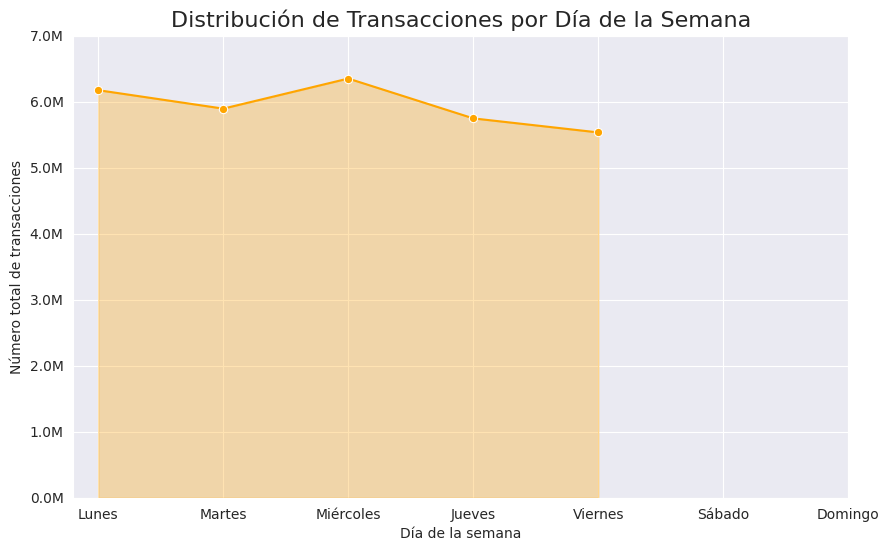

In [63]:
sns.set_style("darkgrid")

def millones(x, pos):
    return f'{x*1e-6:.1f}M'

transactions_per_weekday = aggregated_df.groupby('Weekday')['num_transactions'].sum()

plt.figure(figsize=(10, 6))
sns.lineplot(x=transactions_per_weekday.index, y=transactions_per_weekday.values, marker='o', color='orange')
plt.fill_between(transactions_per_weekday.index, transactions_per_weekday.values, color='orange', alpha=0.3)
plt.title('Distribución de Transacciones por Día de la Semana', fontsize=16)
plt.xlabel('Día de la semana')
plt.ylabel('Número total de transacciones')

plt.xticks(ticks=range(7), labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(millones))

plt.ylim(0, 7000000) 
plt.show()

In [43]:
aggregated_df.groupby('Weekday')['num_transactions'].sum()

Weekday
0    6174920
1    5895267
2    6351232
3    5747803
4    5534868
Name: num_transactions, dtype: int64

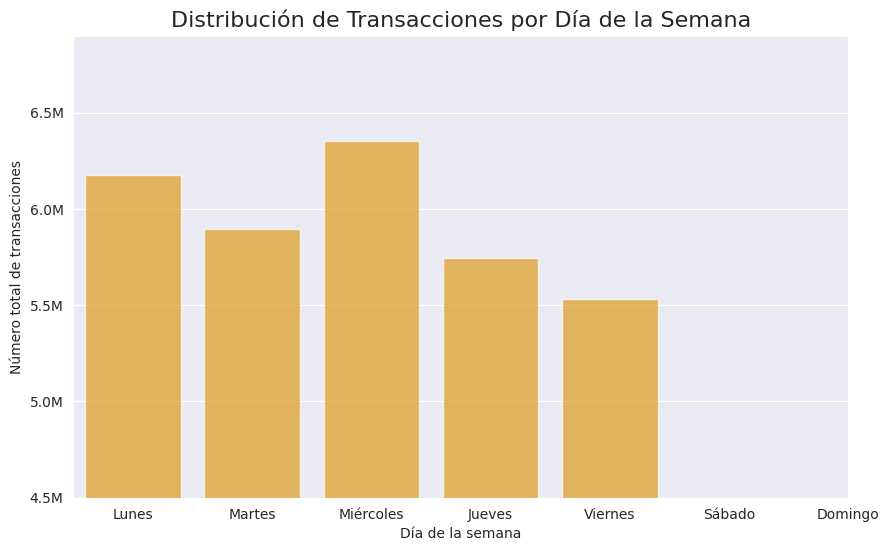

In [73]:
sns.set_style("darkgrid")

def millones(x, pos):
    return f'{x*1e-6:.1f}M'

transactions_per_weekday = aggregated_df.groupby('Weekday')['num_transactions'].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=transactions_per_weekday.index, y=transactions_per_weekday.values, color='orange', alpha=0.7)
plt.title('Distribución de Transacciones por Día de la Semana', fontsize=16)
plt.xlabel('Día de la semana')
plt.ylabel('Número total de transacciones')

plt.xticks(ticks=range(7), labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(millones))

plt.ylim(4500000, 6900000) 
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


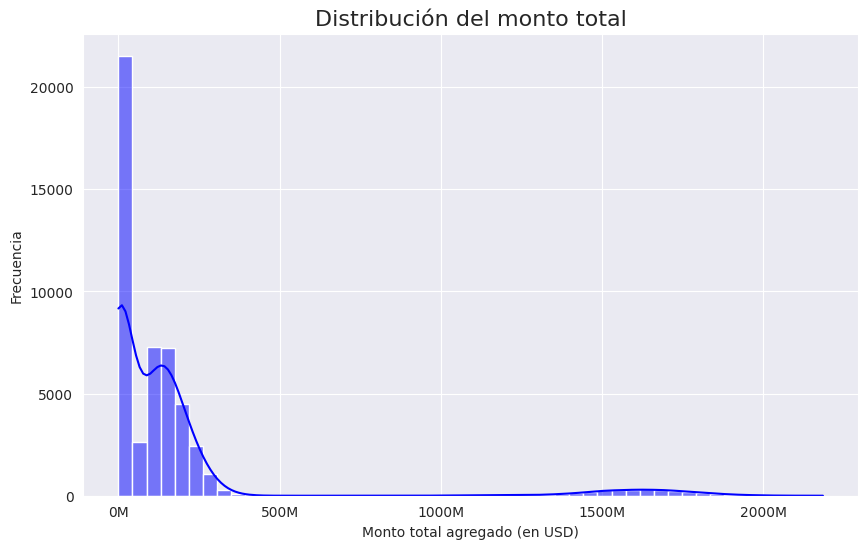

In [62]:
def millones(x, pos):
    return f'{x*1e-6:.0f}M'

sns.set_style("darkgrid")

plt.figure(figsize=(10, 6))
sns.histplot(aggregated_df['total_amount_traded'], bins=50, kde=True, color='blue')

plt.title('Distribución del monto total', fontsize=16)
plt.xlabel('Monto total agregado (en USD)')
plt.ylabel('Frecuencia')

ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(millones))

plt.show()

In [68]:
anomaly_counts = aggregated_df.groupby('Anomaly').size().reset_index(name='Cantidad')

print(anomaly_counts)

   Anomaly  Cantidad
0        0     47990
1        1       631
2        2       511
3        3       282
4        4       254
5        5       252
